
# Music Genre Classification based on Audio Analysis

##### Last updated on December 6th, 2022 by Matthew Lynch and Kalonji Harrington


## “Pop” music vs “Popular” music?

When people use the term “*pop music*” they could be referring either to popular music (as in music that is popular or trending) or a more specific genre distinct from metal, jazz, rap, indie, and other established genres. The discussion as to what constitutes the genre of pop music is a complicated one as the genre continuously evolves–branching out and [borrowing musical elements from other styles like rock, dance, Latin, and country music](https://en.wikipedia.org/wiki/Pop_music). The genre of pop also typically aligns with what is currently popular at a given time and Wikipedia suggests *“that the term "pop music" may be used to describe a distinct genre, designed to appeal to all.”* Yet when examining the top hits from the last two decades, there are some tracks that probably wouldn’t be considered as emblematic of the “pop” genre, but rather a subgenre or a different style altogether.

The discussion of popular music is also complex as the current notion of *“good”* music relies heavily on subjective opinions influenced by our culture today. The types of songs that are popular in the United States in 2022 differs from the hit songs of 2005 and might not even be the same as what is currently trending in other countires like Spain or South Korea. Because of this I want to make it clear that the goal of this project is **not to define what** ***"good"*** **music is** but merely to examine trends in the most frequently played tracks.

To clarify, for this project rather than analyzing music from a particular genre, I am analyzing **popular music in the United States from January 1st, 2000 to today** (March 16th, 2022) with the intent of determining if certain combinations of musical qualities are more likely to create hit songs than others. While the process of creating music isn't necessarily so straightforward, information about what the most popular song duration, tempo, key signature, or even volume could provide a guideline for people who wish to create their own popular music.


## Billboard Hot 100

To determine which songs are the most popular, I chose to use [Billboard charts](https://www.billboard.com/charts/). I wanted data on the most popular songs within the United States and for how long they have been popular without relying on a specific streaming service. While music streaming services keep track of how often a song is played, managing to collect the total number of times a given track has been played on different services would be an incredibly time consuming task. When searching for an alternative, I found [Billboard Magazine](https://www.billboard.com/) which focuses its brand on constructing charts and reporting on music news and trends across different genres of music. The Billboard Hot 100 acts as a [music industry standard record chart](https://en.wikipedia.org/wiki/Billboard_Hot_100) and provides information taking into considering all of the most common ways to consume music today. The tooltip on the Hot 100 Charts says the following:

> The week’s most popular songs, ranked by audio and video streaming activity on leading digital music services, radio airplay audience impressions based on monitored airplay and sales data, all compiled by Luminate. Audience totals are derived, in part, using certain Nielsen Audio listener estimates.”

They also provide a variety of charts such as the Billboard Global 200, Billboard Global Excluding US, Hot Country Songs, Top Latin Albums, and more.


### Spotify Web Api

After using the Billboard Hot 100 charts to obtain a list of popular songs, I looked for other websites to scrape relevant song data from. After spending some time looking, I ended up deciding to use [Spotify's Web API](https://developer.spotify.com/). The API provides access to user specfic data such as playlists and saved music alongside more general public data, such as information about the tracks Spotify has access to. This project doesn't need user specific information, so only client side authentication was needed.

After creating an account with Spotify, I created a project on the dashboard to obtain the client side credentials needed to access the Web API. With those credentials I was able to use the python library [spotipy](https://spotipy.readthedocs.io/en/2.19.0/#) to run the API within python. For the authentication, I stored the clientID and clientSecretID on my local device in a file name `config.py` 

If you are trying to run this project yourself, make sure to create a `config.py` on your local device and add your credentials to it. The `import config` will allow this project to access the credentials and subsequently allow proper requests to the Web API.

The Spotify Web API was used to obtain Spotify's audio analysis data which analyzes samples from a given track and records values for duration, loudness, tempo, time signature, tempo, key, and the mode (minor or major) of the song along with the corresponding confidence values.


## Data Collection

Now with all of the basic information covered, we can now go ahead with obtaining the data. Throughout the project, the dataframes are exported to csv files which are considerably faster to read than manually scraping the data gain as there are a lot of weeks in over two decades with each week having 100 songs each.



### Collecting Billboard Top 100 Data

To begin, we first want to scrape the information from the Billboard Hot 100 pages. We're looking to obtain the ranking of each song, the song titles, the artist names, and the number of weeks the song has been in the Hot 100. 

In [2]:
# Import libraries for data collection
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup as bs
import datetime as dt
import re

# Returns a formatted string from a datetime to use when scraping Billboard charts
def format_datetime(datetime):
    return str(datetime.year).zfill(4) + "-" + str(datetime.month).zfill(2) + "-" + str(datetime.day).zfill(2) 

# Returns a formatted string given a string containing artist name(s)
def format_name(name):
    # Fixes the formatting of the ampersand
    amp = re.sub('&amp;', "&", name)
    # Standardizes ways of featuring an artist to "ft."
    ft = re.sub('(Featuring)|(featuring)|(feat\.?)', "ft.", amp)
    return ft

# Removes html tags from a string
def remove_tags(tag, string):
    tag1 ='<' + tag + '.*?>\s*'
    tag2 = '\s*</' + tag + '.*?>'
    return re.sub(tag2, "", re.sub(tag1, "", string))

# Scrapes data from a specified billboard page in a given period of time
def scrape_billboard(start_date, end_date, page):
    info_list = []
    date = start_date
    # Continues to scrape from new pages until the end date is reached
    while date <= end_date:
        # Access the proper url given the date
        billboard_url = "https://www.billboard.com/"  + page + format_datetime(date) + "/"
        soup = bs(rq.get(billboard_url).content)
        # Look for individual song entries
        charts = soup.find_all("div", class_=re.compile('o-chart-results-list-row-container'))
        for entry in charts:
            # Scrape the data from the chart
            rank = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-font-primary-bold-l'))))
            title = remove_tags("h3", str(entry.find("h3", class_=re.compile('c-title'))))
            artist = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-no-trucate'))))
            # Properly format the title and artist for ease of use later
            title = format_name(title)
            artist = format_name(artist)
            # Find Last_Week, Peak_Pos, and Wks_on_Chart info
            search = entry.find_all("span", class_=re.compile('(c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max)|(c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max)'))
            "c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max"
            # Grab the data on the weeks on the chart
            weeks = remove_tags("span", str(search[2]))

            # Add the data to the info_list
            page_name = "Weeks_in_" + re.sub('charts/|/', "_", page).strip("_")
            data = {'Rank': rank, 'Title': title, 'Artist': artist, 'Week': date, page_name: weeks}
            info_list.append(data)
        # Increment the date by a week (Billboard's charts are on a weekly basis)
        date += dt.timedelta(days = 7)
    # Return a dataframe from the info_list
    return pd.DataFrame(info_list)

# Scrape hot-100 data from 01-01-2000 to today
# billboard_data = scrape_billboard(dt.date(2000, 1, 1), dt.date.today(), "charts/hot-100/")
# Track the first and last week a track enters the hot-100 charts instead of each week that the data is in the hot-100
# billboard_data.insert(5, "First_Week", billboard_data['Week'], False)
# billboard_data.insert(6, "Last_Week", billboard_data['Week'], False)
# billboard_data.drop(columns=['Week'], inplace=True)

# Export to a csv to save time in subsequent calls
# billboard_data.to_csv("csv/billboard_data.csv")

While we could have used global data instead of the Hot 100, I chose to use the Hot 100 as I am personally more familiar with the music in the United States. I don't have a reference point for what is popular overseas, so the data within the United States makes more sense for me to process given that I would likely create music for the United States market in mind. It is entirely feasible to look at the different charts instead of the Hot 100 if so desired. The `page` parameter in `scrape_billboard()` allows different charts to be passed using the same function definition.

Additionally, although we haven't finished scraping all of the data (since we haven't used the Spotify Web API just yet), I went ahead and started to format the data just to make additional scraping easier. The Billboard Hot 100 charts formatted ampersands differently, so I replaced their string with a simple ampersand just to make the subsequent regular expressions easier to handle. I also standardized the usage of "Featuring" or "featuring" or "feat." to just be "ft." since consistent expressions are easier to handle.


### Collecting Spotify Data Based On Billboard Data

Now that the data from the Billboard charts has been collected, we can now group the data by the titles (removing duplicate entries) and extract other information using Spotify's API. The grouping is done mainly to save time as otherwise we would be extracting the same information from a song multiple times if it appears on the charts multiple weeks in a row.

In [2]:
# Import libraries for spotipy and the config file needed to authenticate our client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config

# Read the billboard data and drop the extra row from the index
billboard_data = pd.read_csv("csv/billboard_data.csv").iloc[:, 1:]

# Group the data properly using the specified aggregation functions
aggregation_functions = {'Rank': "min", 'Weeks_in_hot-100': "max", 'First_Week': "min", 'Last_Week': "max"}
spotify_data = billboard_data.groupby(['Title', 'Artist']).aggregate(aggregation_functions).reset_index()

# Effectively relabel the Rank row as Top Rank
spotify_data.insert(0, "Top_Rank", spotify_data['Rank'], False)
spotify_data.drop(columns=['Rank'], inplace=True)

# Create an instance of spotipy and store the authentication token with the client credential manager
authentication = SpotifyClientCredentials(client_id=config.cid, client_secret=config.csecret)
sp = spotipy.Spotify(client_credentials_manager=authentication)

# Returns an array with all of the analysis data based on the query results given an artist and a song title
def get_audio_analysis(artist, title):
    # Specify the artist to avoid picking a random song
    q = "{} artist:{}".format(title, artist)
    result = sp.search(q, type='track', limit=1)['tracks']['items']
    # Check if the search was sucessful
    if result == []:
        # If the initial search failed, try again specifying w/ the track tag
        q = "track:{} artist:{}".format(title, artist)
        result = sp.search(q, type='track', limit=1)['tracks']['items']
        # Check if it failed again
        if result == []:
            # No result was able to be found
            return [None, None, None, None, None, None, None, None, None, None]
    
    # Get the SpotifyID from the given search (used for uniquely identifying a track)
    spotify_id = result[0]['id']
    # Try to run the audio analysis (some songs don't have audio analysis yet or don't exist in Spotify's library)
    try:
        analysis = sp.audio_analysis(spotify_id)
    except spotipy.client.SpotifyException:
        # If it failed, no result was found
        return [None, None, None, None, None, None, None, None, None, None]

    # Find the relevant information from the analysis
    duration = analysis['track']['duration']
    loudness = analysis['track']['loudness']
    tempo = analysis['track']['tempo']
    tempo_conf = analysis['track']['tempo_confidence']
    time_sig = analysis['track']['time_signature']
    time_sig_conf = analysis['track']['time_signature_confidence']
    key = analysis['track']['key']
    key_conf = analysis['track']['key_confidence']
    mode = analysis['track']['mode']
    mode_conf = analysis['track']['mode_confidence']
    # Return the array
    return [duration, loudness, tempo, tempo_conf, time_sig, time_sig_conf, key, key_conf, mode, mode_conf]

# Declare empy lists for each variable
duration_list = []
loudness_list = []
tempo_list = []
tempo_conf_list = []
time_sig_list = []
time_sig_conf_list = []
key_list = []
key_conf_list =[]
mode_list = []
mode_conf_list = []

# Run the analysis for each unique title in the dataset
for index, row in spotify_data.iterrows():
    # Create a list of artists, removing all other characters
    string = re.sub('\(|\)', ", ", re.sub('\s+((ft\.)|&|X|x|(\+)|/)\s+', ", ", row['Artist'])).strip(', ')
    artist_list = string.split(",")

    # Try running the analysis until a result if found (sometimes searching an artist wouldn't yield proper results)
    # i.e. "Leave the Door Open" by Silk Sonic, Bruno Mars, ... would only produce a result if Bruno Mars was used
    values = [None, None, None, None, None, None, None, None, None, None]
    for artist in artist_list:
        if values == [None, None, None, None, None, None, None, None, None, None]:
            # Remove parenthesis from the title to avoid the title being too long
            # This was an issue with a Taylor Swift's Christmas Tree Farm (Old Timey Version)
            values = get_audio_analysis(artist, re.sub('\(.*\)', "", row['Title']))
    
    # Add the results from the analysis to the lists
    duration_list.append(values[0])
    loudness_list.append(values[1])
    tempo_list.append(values[2])
    tempo_conf_list.append(values[3])
    time_sig_list.append(values[4])
    time_sig_conf_list.append(values[5])
    key_list.append(values[6])
    key_conf_list.append(values[7])
    mode_list.append(values[8])
    mode_conf_list.append(values[9])

# Add the data to the dataframe
spotify_data.insert(6, "Duration", duration_list, False)
spotify_data.insert(7, "Loudness", loudness_list, False)
spotify_data.insert(8, "Tempo", tempo_list, False)
spotify_data.insert(9, "Tempo_Confidence", tempo_conf_list, False)
spotify_data.insert(10, "Meter", time_sig_list, False)
spotify_data.insert(11, "Meter_Confidence", time_sig_conf_list, False)
spotify_data.insert(12, "Key", key_list, False)
spotify_data.insert(13, "Key_Confidence", key_conf_list, False)
spotify_data.insert(14, "Mode", mode_list, False)
spotify_data.insert(15, "Mode_Confidence", mode_conf_list, False)

# Export the spotify data to a csv
# spotify_data.to_csv("csv/spotify_data_2000_01_01.csv")

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/72ozIjVFHpAnKGcuYpCfb7 with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/6yuvC80FcnVJNvC0DbXN9e with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/6yuvC80FcnVJNvC0DbXN9e with Params: {} returned 404 due to analysis not found


KeyboardInterrupt: 

There were a few problems that I encountered when working on using the Spotify Web API to querey results. The first issue was when songs that were on Spotify weren't being properly found. Some songs like *Leave The Door Open* by Bruno Mars, Anderson .Paak, and Silk Sonic had some issues due to how complicated the original artist string was. Directly imported from the Billboard charts, the artist strings for each song could be formatted in multiple different ways. After running the below code, I was able to find patterns in songs that failed to properly query. The solution was converting the artists strings into a list of individual artists who are credited for the song and searching multiple times with each artist to maximize the chance that the correct song is chosen. Another similar issue I noticed was with *Christmas Tree Farm (Old Timey Version)* by Taylor Swift as the parenthesis made the query too long for the API to properly handle.

Additionally some songs don't have the audo analysis available in Spoity's API. Some songs like Camila Cabello's *I'll Be Home for Christmas* is only available on Amazon Music and other songs like Shawn Mendes' *Lost in Japan* didn't have an available audio analysis in the API and returned:

`HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/0BXTqB4It8UM09lCaIY3Jk with Params: {} returned 404 due to analysis not found`

In [3]:
# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2000_01_01.csv").iloc[:, 1:]
# Create a dataframe with only the missing values
null_data = df[df.isnull().any(axis=1)]

# Print info about missing data
print("Total number of tracks: " + str(len(df.index)))
print("Total number of tracks w/ missing data: " + str(len(null_data.index)))
print("Percentage of data with complete data: " + str(100*(1- len(null_data.index)/len(df.index))) + "%")

# Display some of the missing songs
null_data.head(10)

Total number of tracks: 8486
Total number of tracks w/ missing data: 269
Percentage of data with complete data: 96.83007306151308%


,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,Meter,Meter_Confidence,Key,Key_Confidence,Mode,Mode_Confidence
44,59,15 Minutes,Marc Nelson,16,2000-01-01,2000-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,57,9 AM In Dallas,Drake,1,2010-07-03,2010-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,8,95.south,J. Cole,3,2021-05-29,2021-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,66,A Broken Wing,Jordin Sparks,2,2007-06-09,2007-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,56,A Change Is Gonna Come,Adam Lambert,1,2009-06-06,2009-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,75,A Country Boy Can Survive (Y2K Version),Chad Brock With Hank Williams Jr. & George Jones,3,2000-01-01,2000-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,37,Ain't No Sunshine,Kris Allen,2,2009-06-06,2009-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,77,All These N**gas,King Von ft. Lil Durk,1,2020-11-21,2020-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,67,Always Be My Baby,David Cook,1,2008-06-07,2008-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,67,And Then What,Young Jeezy ft. Mannie Fresh,11,2005-07-23,2005-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, the data is only missing 269 out of 8486 different tracks. In the future I may go back and find other methods of accessing the missing data using other APIs, through I would need to adjust for the potential differences in how the missing data is calculated in comparison to Spotify's audio analysis.

Spotify also had another way of obtaining data through the *Get Tracks' Audio Features* as opposed to the *Get Track's Audio Analysis*, however, I chose not to use the audio features to fill the missing data as the audio features lacks the confidence data that I collected from the audio analysis call. The confidence data is a floating point value from 0 to 1 that indicates the confiendce of Spotify's prediction of a value (key, time signature, etc.). It's also worth noting that Spotify also created their own metrics such as "Acouticness", "Danceability", "Speechiness", and "Valence", but seeing as these metrics were less well defined (i.e. Valence refers to the "musical positiveness conveyed by a track") and the methods for obtaining such data was more ambiguous, I decided to omit them from this dataset.


## Data Representation

The goal now is to make the data more readable and easier to work with. To begin with we can drop the missing data from the dataframe. I would claim that the data is missing at random since there isn't an obvious trend as to why particular songs don't have an audio analysis for them. Additionally the songs that are missing due to not being available on Spotify are also missing at random as the list of popular music was obtained through scraping the Billboard Hot 100 charts which doesn't value which services a song is avaiable through.

The values of some of the columns were also adjusted to go from their floating point representations to strings that are more easily understood. For example, the key of a song is now represented with a letter name as opposed to a float between -1 and 11.

In [4]:
# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2000_01_01.csv").iloc[:, 1:]
# Drop the missing data
df = df.dropna()

# Returns a string with the correctly formatted time signature (no longer a float)
def display_time_sig(time_sig):
    return str(int(time_sig)) + "/4"

# Returns a string corresponding to the key identified by pitch class
def display_key(key):
    if key == 0:
        return "C"
    elif key == 1:
        return "C#/Db"
    elif key == 2:
        return "D"
    elif key == 3:
        return "D#/Eb"
    elif key == 4:
        return "E"
    elif key == 5:
        return "F"
    elif key == 6:
        return "F#/Gb"
    elif key == 7:
        return "G"
    elif key == 8:
        return "G#/Ab"
    elif key == 9:
        return "A"
    elif key == 10:
        return "A#/Bb"
    elif key == 11:
        return "B"
    else:
        return "Error"

# Returns true if the mode is major
def display_mode(num):
    return "Major" if num > 0 else "Minor"

# Update the columns

df.insert(10, "Meter_Display", df["Meter"].apply(display_time_sig), False)
df.insert(13, "Key_Display", df["Key"].apply(display_key), False)
df.insert(16, "Mode_Display", df["Mode"].apply(display_mode), False)
df.sort_values(by=['Weeks_in_hot-100'], ascending=False, inplace=True)
df.head(20)

,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,Meter_Display,Meter,Meter_Confidence,Key_Display,Key,Key_Confidence,Mode_Display,Mode,Mode_Confidence
908,1,Blinding Lights,The Weeknd,90,2019-12-14,2021-09-04,200.04000,-5.934,171.005,0.875,4/4,4.0,1.000,C#/Db,1.0,0.000,Major,1.0,0.152
5760,3,Radioactive,Kings Of Leon,87,2010-10-02,2014-05-10,206.18668,-4.880,126.405,0.345,4/4,4.0,1.000,F,5.0,0.468,Major,1.0,0.394
6067,17,Sail,AWOLNATION,79,2011-09-03,2014-03-22,259.09332,-9.583,119.051,0.847,4/4,4.0,1.000,C#/Db,1.0,0.745,Major,1.0,0.447
4175,2,Levitating,Dua Lipa,77,2020-10-17,2022-05-07,203.06416,-3.787,102.977,0.925,4/4,4.0,0.994,F#/Gb,6.0,0.263,Minor,0.0,0.220
3582,6,I'm Yours,Jason Mraz,76,2008-05-03,2009-10-10,242.94667,-9.331,150.960,0.261,4/4,4.0,1.000,B,11.0,0.592,Major,1.0,0.609
6110,1,Save Your Tears,The Weeknd & Ariana Grande,69,2020-04-04,2022-05-07,215.62666,-5.487,118.051,0.857,4/4,4.0,0.857,C,0.0,0.326,Major,1.0,0.500
5493,1,Party Rock Anthem,LMFAO ft. Lauren Bennett & GoonRock,68,2011-02-12,2012-07-21,262.17334,-4.210,129.993,0.616,4/4,4.0,1.000,F,5.0,0.419,Minor,0.0,0.483
2946,1,Heat Waves,Glass Animals,68,2021-01-16,2022-05-14,238.80508,-6.900,80.870,0.304,4/4,4.0,1.000,B,11.0,0.404,Major,1.0,0.420
1499,2,Counting Stars,OneRepublic,68,2013-07-06,2014-10-18,257.84000,-4.972,122.017,0.541,4/4,4.0,0.909,C#/Db,1.0,0.626,Minor,0.0,0.681
5983,1,Rolling In The Deep,Adele,65,2010-12-25,2012-04-14,228.09332,-5.114,104.948,0.380,4/4,4.0,0.966,G#/Ab,8.0,0.787,Major,1.0,0.659


# Unsupervised Learning
## K-Means Clustering

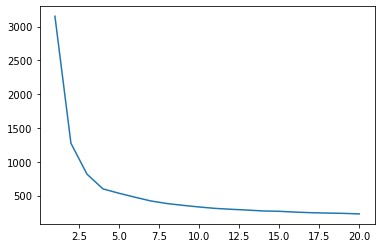

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kMeansHyperpameterCurve(X, kVals):
    inertias = []

    for k in kVals:
        # new model with "k" centroids
        model = KMeans(k)

        model.fit(X)

        # inertia is mean squared error within each cluster
        inertias.append(model.inertia_)
    
    plt.plot(kVals, inertias)
    plt.show()

# choose the relevant numeric comlumns
X = df[["Duration", "Loudness", "Tempo", "Meter", "Key", "Mode"]]
# normalize the columns so all values are within 0 and 1
X = X.apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)

# create hyperparameter curve
kMeansHyperpameterCurve(X, range(1, 21))

In [32]:
import sklearn.model_selection as sk_ms
from sklearn import metrics



TypeError: learning_curve() missing 2 required positional arguments: 'X' and 'y'

# Supervised Learning
## One Versus All

In [12]:


train, test = sk_ms.train_test_split(df, train_size=0.7)

2
